# Background
Provided is data from the gold mining sector regarding extraction and purification. A ML model will be developed to predict the amount of gold recovered from gold ore using y_values *rougher concentrate recovery* and *final concentrate recovery*. The business use of this model will help to optimize the production and eliminate unprofitable parameters.

Mined ore undergoes primary processing to get the ore mixture or rougher feed, which is the raw material for flotation (also known as the rougher process). After flotation, the material is sent to two-stage purification which then leads to the final concentrate output. 

# Prepping Data

In [1]:
import pandas as pd 
import numpy as np 

#csv not included due to private data reasons 
traindf = pd.read_csv('gold_recovery_train.csv') 
testdf = pd.read_csv('gold_recovery_test.csv')
fulldf = pd.read_csv('gold_recovery_full.csv')

#the date column is converted from object to date time type
traindf['date']= pd.to_datetime(traindf['date'], format= '%Y-%m-%d %H:%M:%S') 

In [2]:
traindf.head(2)

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184


In [3]:
#dropping NaN values in all the dataframes
traindf = traindf.dropna()
testdf = testdf.dropna()
fulldf = fulldf.dropna()

#### Double checking if the recovery column was calculated correctly. Measuring it using mean absolute error. Could have also used the mae import from sklearn.

In [4]:
C = traindf['rougher.output.concentrate_au'] #C — share of gold in the concentrate right after flotation
F = traindf['rougher.input.feed_au'] #F — share of gold in the feed before flotation
T = traindf['rougher.output.tail_au'] #T — share of gold in the rougher tails right after flotation

traindf['recovery'] = ((C * (F-T)) / (F * (C-T))) * 100

In [5]:
real_recovery = traindf['rougher.output.recovery']
MAE = np.sum(np.abs(traindf['recovery'] - real_recovery)/len(real_recovery))
print(MAE)

9.555596961987513e-15


Error is basically non-existant, we can move forward with confidence that this column is calculated correctly

#### Among the training and test dataset .csv files, there are column discrepancies which will pose a significant issue when fitting and predicting values down the road. 

In [6]:
#traindf.columns.intersection(testdf.columns)
# the columns that are shared between the training and test data set 

In [7]:
not_in_test = traindf.columns.difference(testdf.columns)
not_in_test = not_in_test.tolist()
not_in_test.remove('rougher.output.recovery') #removing these two columns because they will be appearing in the test dataset 
not_in_test.remove('final.output.recovery')
not_in_test

['final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'recovery',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.tail_pb',
 'rougher.output.tail_sol',
 'sec

Above shows all the columns that are included in the training data set, but do not appear in the test data set. That's a lot of columns! This means we can not include these columns when it comes to developing the model for both the training and testing side. 

# Analyze the data

### Analyzing changes in concentrations of metals (Au, Ag, Pb) based on purification stage

There are two purification stages, First Stage of Cleaner Process and Second Stage of Cleaner Process. This means that the concentration of metals changes three times from pre-first stage, post-first stage, and post-second stage. Below are the columns that are affiliated with these stages.

##### Purification Analysis: Au

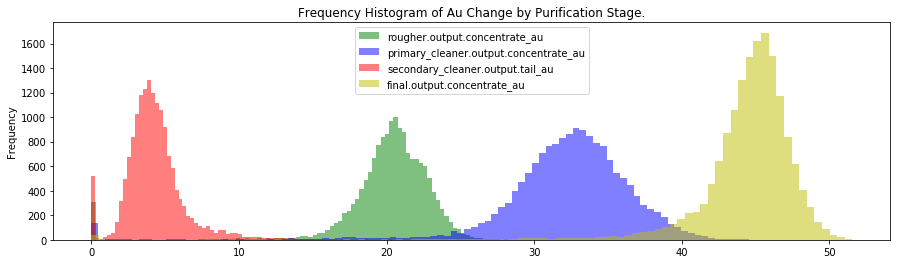

In [8]:
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots(figsize=(15, 4))
ax1.hist(fulldf['rougher.output.concentrate_au'], 
                     alpha=0.5, bins=100, color='g', label='rougher.output.concentrate_au')
ax1.hist(fulldf['primary_cleaner.output.concentrate_au'], 
         alpha=0.5, bins=100, color='b', label='primary_cleaner.output.concentrate_au')
ax1.hist(fulldf['secondary_cleaner.output.tail_au'], alpha=0.5, bins=100, color='r', label='secondary_cleaner.output.tail_au')
ax1.hist(fulldf['final.output.concentrate_au'], alpha=0.5, bins=100, color='y', label='final.output.concentrate_au')
plt.gca().set(title='Frequency Histogram of Au Change by Purification Stage.', ylabel='Frequency')
ax1.legend()

The histograms of the concentrations during the purification processes for Au are cleanly laid out here. Each stage is within it's own concentration range denoted by the x-axis and there is minimal overlap. The concentration before entering the first purification stage is seen as green, and the concentration is further increased after the first stage of purification seen in blue. Secondary cleaner output has low concentration values, but we need to keep in mind that it is also branched apart form the final.output.concentrate for Au as well.

##### Purification Analysis: Pb

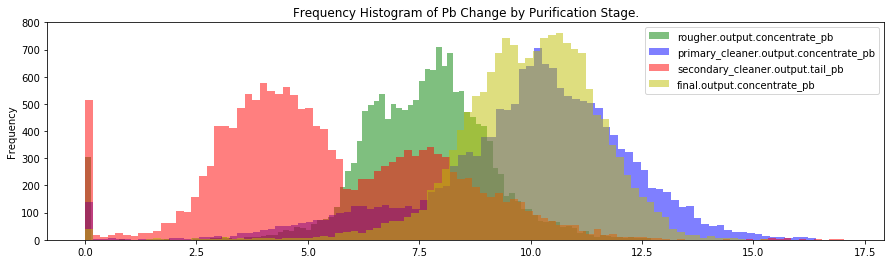

In [9]:
fig, ax1 = plt.subplots(figsize=(15, 4))
ax1.hist(fulldf['rougher.output.concentrate_pb'], 
                     alpha=0.5, bins=100, color='g', label='rougher.output.concentrate_pb')
ax1.hist(fulldf['primary_cleaner.output.concentrate_pb'], 
         alpha=0.5, bins=100, color='b', label='primary_cleaner.output.concentrate_pb')
ax1.hist(fulldf['secondary_cleaner.output.tail_pb'], 
         alpha=0.5, bins=100, color='r', label='secondary_cleaner.output.tail_pb')
ax1.hist(fulldf['final.output.concentrate_pb'], 
         alpha=0.5, bins=100, color='y', label='final.output.concentrate_pb')
plt.gca().set(title='Frequency Histogram of Pb Change by Purification Stage.', ylabel='Frequency')
ax1.legend()

Not nearly as clean as the Au histograms, but the histograms still tell a similar story (just a lot more tight knit). The concentraiton before purification sits around the middle of the other concentration values of the other histograms. After going through the first purification process, the concentration is increased as seen by the blue, just like the Au graph. After the second purification process, a split between the secondary output and final output is seen again with red being closer to zero and yellow being near the upper end. The concentration values between the first purification process and final output are near identitical compared to a large difference seen in Au.

##### Purification Analysis: Ag

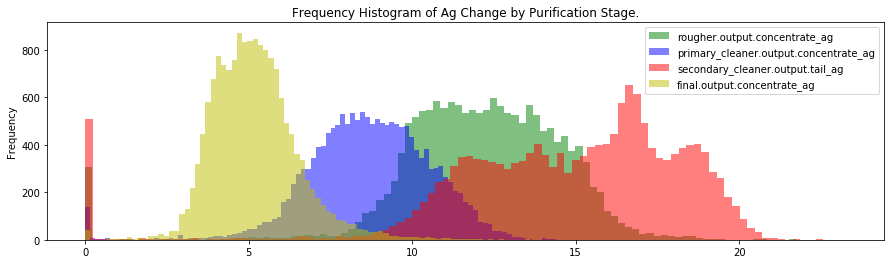

In [10]:
fig, ax1 = plt.subplots(figsize=(15, 4))
ax1.hist(fulldf['rougher.output.concentrate_ag'], 
                     alpha=0.5, bins=100, color='g', label='rougher.output.concentrate_ag')
ax1.hist(fulldf['primary_cleaner.output.concentrate_ag'], 
         alpha=0.5, bins=100, color='b', label='primary_cleaner.output.concentrate_ag')
ax1.hist(fulldf['secondary_cleaner.output.tail_ag'], 
         alpha=0.5, bins=100, color='r', label='secondary_cleaner.output.tail_ag')
ax1.hist(fulldf['final.output.concentrate_ag'], 
         alpha=0.5, bins=100, color='y', label='final.output.concentrate_ag')
plt.gca().set(title='Frequency Histogram of Ag Change by Purification Stage.', ylabel='Frequency')
ax1.legend()

The histogram distribution here is interesting because it shows the inverse of the last two graphs that we saw. As Ag goes through the purification process, we see the concentration go down. It really does seem like it's the previous graph, but flipped horizontally. The highest concentration is seen from the secondary prufication output and the lowest concentration is the final output concentration.

### Analyzing the feed particle size distributions in the training set and in the test set. If the distributions vary significantly, the model evaluation will be incorrect.

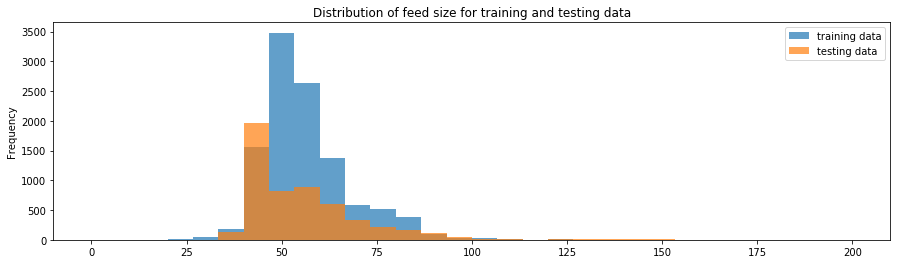

In [11]:
ax = traindf['rougher.input.feed_size'].plot(kind='hist', bins=30,range=(0,200),alpha=0.7,label='training data',legend=True)
plot = testdf['rougher.input.feed_size'].plot(kind='hist',y='Frequency',
                                              title='Distribution of feed size for training and testing data',
                                              range=(0,200),figsize=(15,4),bins=30,alpha=0.7,label='testing data',legend=True)

The distribution of feed size for the training and testing data sets are quite similar. Of course the the testing data has a fraction of observations compared to the traning data which explains why it has a smaller frequency value. The right skewed curve and the mode around 50 still remains the same for both charts.

### Analyzing the total concentrations of all substances at different stages: raw feed, rougher concentrate, and final concentrate. 

#### Raw Feed

In [12]:
raw_feed_items = ['rougher.input.feed_au','rougher.input.feed_ag','rougher.input.feed_pb']
raw_feed = pd.Series(dtype='float')
for i in raw_feed_items:
    raw_feed = raw_feed.append(fulldf[i])

Number of all elements in raw feed: 48282
Number of elements in raw feed greather than 13: 1339
Percent of raw feed concentration elements greater than 13: 0.028


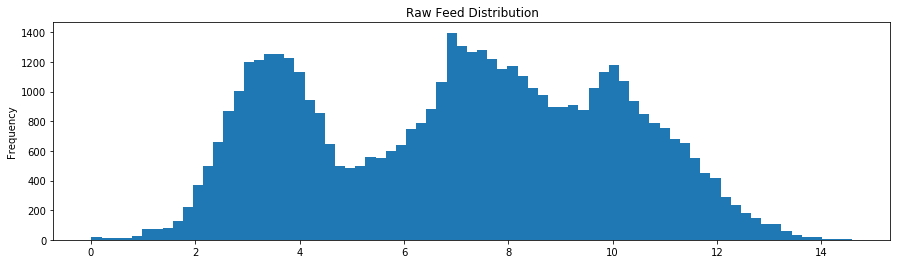

In [13]:
raw_feed.plot(kind='hist', bins=75,figsize=(15,4),title='Raw Feed Distribution')
print('Number of all elements in raw feed:',len(raw_feed))
print('Number of elements in raw feed greather than 13:',len(raw_feed[raw_feed > 12]))
print('Percent of raw feed concentration elements greater than 13:',round(len(raw_feed[raw_feed > 12]) / len(raw_feed),3))

After combining all element concentrations for raw feed/rougher.input.feed, we can see a distribution a cyclical distribution for x-axis ranges of 2-12 with a maximum frequency of around 2000. The tail end of of the distribution is potentially an outlier so items after 13 will be removed to keep a cleaner tail. 

In [14]:
for i in raw_feed_items:
    traindf = traindf[traindf[i] < 13]
    testdf = testdf[testdf[i] < 13]
    fulldf = fulldf[fulldf[i] < 13]

##### Rougher concentrate

In [15]:
rough_con_items = ['rougher.output.concentrate_au','rougher.output.concentrate_ag','rougher.output.concentrate_pb']
rough_con = pd.Series(dtype='float')
for i in rough_con_items:
    rough_con = rough_con.append(fulldf[i])

Number of all elements in rougher concentrate feed: 47478
Number of elements in rougher concentrate feed greather than 25: 201
Percent of rougher concentration elements greater than 25: 0.004


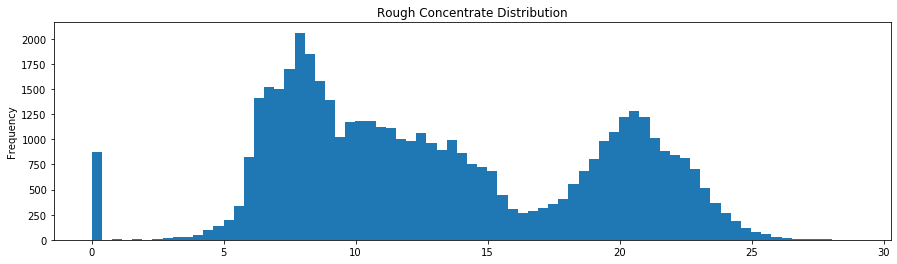

In [16]:
rough_con.plot(kind='hist', bins=75,figsize=(15,4),title='Rough Concentrate Distribution')
print('Number of all elements in rougher concentrate feed:',len(rough_con))
print('Number of elements in rougher concentrate feed greather than 25:',len(rough_con[rough_con > 25]))
print('Percent of rougher concentration elements greater than 25:',round(len(rough_con[rough_con > 25]) / len(rough_con),3))

For rougher concentrate, it is harder to identify what is considered an outlier here because the histogram of rough concentrate has a stretched distribution with around the same frequency which follows a cyclical pattern. I initially thought of removing elements that are rough concentrate 25 and above since it was the beginning of the last cyclical trough. However, I believe that segment is not an outrageous 20% of data and will remain within the original data set.

In [17]:
for i in rough_con_items:
    traindf = traindf[traindf[i] > 1]
    # testdf = testdf[testdf[i] > 1] #look likes none of the columns appear in testdf
    fulldf = fulldf[fulldf[i] > 1]

##### Final Concentrate

In [18]:
final_con = pd.Series(dtype='float')
final_con = final_con.append(fulldf['final.output.concentrate_au'])
final_con = final_con.append(fulldf['final.output.concentrate_ag'])
final_con = final_con.append(fulldf['final.output.concentrate_pb'])

Number of all elements in raw feed: 46590
Number of elements in raw feed greather than 20: 15447
Percent of final concentration elements greater than 20: 0.332


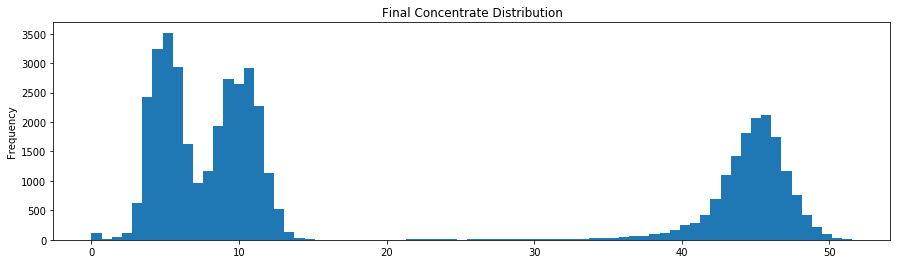

In [19]:
final_con.plot(kind='hist', bins=75,figsize=(15,4),title='Final Concentrate Distribution')
print('Number of all elements in raw feed:',len(final_con))
print('Number of elements in raw feed greather than 20:',len(final_con[final_con > 20]))
print('Percent of final concentration elements greater than 20:',round(len(final_con[final_con > 20]) / len(final_con),3))

The distribution for final concentrate appears bimodal with another noticable increase in frequencies for final concentrate values of 45. This bump in frequencies is relatively far from the rest of the values in the 0 to 20 range. Thus, I will consider this 22% of data as outliers and remove it from the full dataset. 

After further analysis, I identified that a majority of the values in final concentrate greater than 20 came from the final.output.concentrate_au column. 

- Attempting to remove this anomaly by discarding them affects the rest of the final concentrate because those rows had productive data for the other final concentrates. This means the resulting distribution after the discard was just a large frequency mode at zero, and barely any frequency for anything greater than zero.  
- Attempting to replace this anomaly with a median or mean value was not helpful either because the values for final.output.concentrate_au were 44 and 40 respectively. 

I believe the distribution when you group final concentrate together will look odd, but the histogram for Au by itself is productive information and should not be tampered with. 

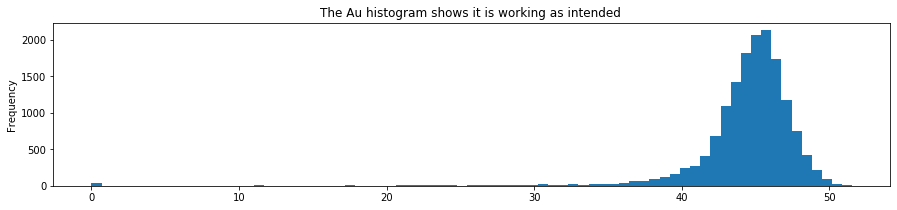

In [20]:
fulldf['final.output.concentrate_au'].plot(kind='hist', bins=75,
                                           figsize=(15,3),title='The Au histogram shows it is working as intended ')

# Model Training

Let's remove all the columns not found in the test dataset to make sure the training and test dataset are compatible

In [21]:
traindf = traindf.drop(not_in_test,axis=1)

### The sMAPE Function
A new metric known as Symmetric Mean Absolute Percentage Error (**sMAPE**) will be used assess the quality of the model's prediction of y_values *rougher concentrate recovery* and *final concentrate recovery*. It is similar to MAE, but is expressed in relative values instead of absolute ones. 

This statistic is being used here because it will perform a better job adjusting MAPE to equally take the scale of both the target and the prediction into account.

In [22]:
def smape(target, pred):
    smape_r = np.mean((np.abs(pred[:,0] - target[:,0])) / (np.abs(target[:,0]) + np.abs(pred[:,0])) /2) * 100
    smape_f = np.mean((np.abs(pred[:,1] - target[:,1])) / (np.abs(target[:,1]) + np.abs(pred[:,1])) /2) * 100
    smape_final = 0.25 * smape_r + 0.75 * smape_f
    return smape_final

### Training different models

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score

In [24]:
features0 = traindf.drop(['rougher.output.recovery','final.output.recovery','date'],axis=1) 
target0 = np.array(traindf[['rougher.output.recovery','final.output.recovery']])

features_train, features_valid, target_train, target_valid = train_test_split(features0, target0, 
                                                                              test_size=0.25, random_state=12345) 

##### Train: Linear Regression

In [38]:
LR_model = LinearRegression(normalize=True)
LR_model.fit(features_train, target_train) 
LR_predict = LR_model.predict(features_valid)
print('Accuracy:', r2_score(target_valid, LR_predict))

Accuracy: 0.47586650643996314


In [26]:
#LR_predict based off features_valid 
smape(target_valid, LR_predict)

1.6181653478915732

My Symmetric Mean Absolute Percentage Error is 1.618% here which is good. However my linear regression mode has a score of 47% which assessing it against the validation dataset which is worse than randomly guessing. 

#### Train: Random Forest Regressor 

In [39]:
for estim in range(5,31,5):
    for depth in range(5,31,5):
        RF_model = RandomForestRegressor(random_state=12345, n_estimators=estim, max_depth = depth) 
        RF_model.fit(features_train, target_train)
        RF_predict = RF_model.predict(features_valid)
        
        smape_score = smape(target_valid, RF_predict)
        print('n_est:',estim,'| depth:',depth,'| smape_score',smape_score)

n_est: 5 | depth: 5 | smape_score 1.6096257074829077
n_est: 5 | depth: 10 | smape_score 1.4117031921804168
n_est: 5 | depth: 15 | smape_score 1.3684726388797852
n_est: 5 | depth: 20 | smape_score 1.3484610153588312
n_est: 5 | depth: 25 | smape_score 1.3436063085692205
n_est: 5 | depth: 30 | smape_score 1.3670971116401391
n_est: 10 | depth: 5 | smape_score 1.5981842022129653
n_est: 10 | depth: 10 | smape_score 1.3642975263653825
n_est: 10 | depth: 15 | smape_score 1.28886321167822
n_est: 10 | depth: 20 | smape_score 1.26057558427086
n_est: 10 | depth: 25 | smape_score 1.25650514455626
n_est: 10 | depth: 30 | smape_score 1.2625036410973907
n_est: 15 | depth: 5 | smape_score 1.600874783873854
n_est: 15 | depth: 10 | smape_score 1.350274104404253
n_est: 15 | depth: 15 | smape_score 1.2591903061929386
n_est: 15 | depth: 20 | smape_score 1.2266921576820293
n_est: 15 | depth: 25 | smape_score 1.2199853918420578
n_est: 15 | depth: 30 | smape_score 1.2289867772719436
n_est: 20 | depth: 5 | smap

Looks like the best hyperparameters to achieve the lowest smape score of 1.1892945 are n_est = 30 and depth = 25. I believe I could have run the hyperparameter loop for longer, but I 1.189% is already pretty low. 

##### Cross-validation

In [40]:
RF_model = RandomForestRegressor(random_state=12345, n_estimators=30, max_depth = 25) 
RF_model.fit(features_train,target_train)
smape_value = make_scorer(smape, greater_is_better = False)
    
scores = cross_validate(RF_model, features_train,target_train, scoring=smape_value, cv=10)
print(scores)

{'fit_time': array([8.32035685, 8.58505368, 8.37192988, 8.50754166, 9.00185299,
       8.55801988, 8.29936194, 8.48812556, 8.51805878, 8.50818157]), 'score_time': array([0.01562524, 0.01562881, 0.01562476, 0.01562309, 0.01564837,
       0.01101255, 0.01100445, 0.01099396, 0.015625  , 0.        ]), 'test_score': array([-1.12934618, -1.14928486, -1.3051113 , -1.32819115, -1.15478535,
       -1.31419405, -1.38851315, -1.16567559, -1.2262511 , -1.19036397])}


In [41]:
avgDict = {}
for k,v in scores.items():
    avgDict[k] = sum(v)/ float(len(v))
avgDict

{'fit_time': 8.515848278999329,
 'score_time': 0.01267862319946289,
 'test_score': -1.2351716694686394}

The default scorer has been replaced with our smape function using sklearn.make_scorer. 
The cross-validation using the K-folds technique of 10 folds provided a test_score (smape) average of about 1.235% (percentages can't be negative so the evaluation metric just needs to be mulitiplied by -1). Using the validation set was not needed because 1/10th of the training dataset acted as the dataset as it went through the various folds. 

This gives confidence that our hyperparametere are working well and can move forward to the test dataset.  

# Running the model on the test dataset

In [42]:
target_test = testdf.merge(fulldf, how = 'inner', on='date')[['rougher.output.recovery','final.output.recovery','date']]
#did this bootleg method to have the same number of rows as target_test
features_test = testdf.merge(target_test, how = 'inner', on='date') 
features_test = features_test.drop(['rougher.output.recovery','final.output.recovery','date'],axis=1)
target_test = target_test.drop(['date'],axis=1)
target_test = target_test.to_numpy()

##### Test: Linear Regression

In [43]:
LR_model_test = LinearRegression()
LR_model_test.fit(features_train, target_train) 
LR_predict_test = LR_model_test.predict(features_test)
#LR_model.score(features_test, target_test)

In [44]:
smape(target_test, LR_predict_test)

1.7887390112323227

##### Test: Random Forest

In [45]:
RF_test = RandomForestRegressor(random_state=12345, n_estimators=30, max_depth = 25) 
RF_test.fit(features_train, target_train)
RF_predict_test = RF_test.predict(features_test)
smape_score_test = smape(target_test, RF_predict_test)
print('final smape:',smape_score_test)

final smape: 2.2475949833815987


##### Cross-validation

In [46]:
scores_test = cross_validate(RF_test, features_test,target_test, scoring=smape_value, cv=10)
print(scores)

{'fit_time': array([8.32035685, 8.58505368, 8.37192988, 8.50754166, 9.00185299,
       8.55801988, 8.29936194, 8.48812556, 8.51805878, 8.50818157]), 'score_time': array([0.01562524, 0.01562881, 0.01562476, 0.01562309, 0.01564837,
       0.01101255, 0.01100445, 0.01099396, 0.015625  , 0.        ]), 'test_score': array([-1.12934618, -1.14928486, -1.3051113 , -1.32819115, -1.15478535,
       -1.31419405, -1.38851315, -1.16567559, -1.2262511 , -1.19036397])}


In [47]:
avgDict = {}
for k,v in scores_test.items():
    avgDict[k] = sum(v)/ float(len(v))
avgDict

{'fit_time': 5.565277409553528,
 'score_time': 0.009113287925720215,
 'test_score': -1.8383796669305874}

Looks like assessing our model with the test dataset has proven successful. The smape scores are a bit higher than our validation scores, but that is to be expected. The average smape value of 1.838% seen from the cross validation is still relatively low which represents how the model is working as intended. 